# PyTorch and CIFAR10 data analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style='white', palette='pastel')

In [3]:
DATA_DIRS = {
    'nogpu': os.path.join('csv', 'fast', '2021-10-19-11-31-50-nogpu'),
    'gpu': os.path.join('csv', 'fast', '2021-10-14-09-16-15-gpu'),
    # 'gpu-2': os.path.join('csv', 'cifar10-fast', '2021-10-14-12-30-14-gpu'),
    # 'gpu-3': os.path.join('csv', 'cifar10-fast', '2021-10-18-15-25-46-gpu'),
    'gpu-cpu1': os.path.join('csv', 'fast', '2021-10-21-15-02-56-gpu-cpu1'),
    'gpu-core1,3,5,7-nohyper': os.path.join('csv', 'fast', '2021-10-25-14-59-44-gpu-core1,3,5,7-nohyper'),
    'gpu-core1-hyper': os.path.join('csv', 'fast', '2021-10-22-12-07-40-gpu-core1-hyper'),
    'gpu-core1-nohyper': os.path.join('csv', 'fast', '2021-10-22-10-10-55-gpu-core1-nohyper')
}

In [4]:
dfs = {}

for name, data_dir in DATA_DIRS.items():
    run_filenames = (
        {int(file.name.split('-')[1][:-4]): file.name
         for file in sorted(list(os.scandir(data_dir)), key=lambda x: x.name)
         if file.is_file() and not file.name.startswith('.')}
    )

    df = pd.concat(
        [pd.concat({num: pd.read_csv(os.path.join(data_dir, filename), index_col='epoch')}, names=['run'])
         for num, filename in list(run_filenames.items())[1:]]
    )
    
    dfs[name] = df
    
df = pd.concat(dfs)
df.index.set_names(['setup', 'run', 'epoch'], inplace=True)

## Preview of the dataframe

In [5]:
df

duration  train acc  valid acc  \
setup             run epoch                                    
nogpu             1   1      85.949808   0.405183     0.5175   
                      2      85.481513   0.658284     0.6789   
                      3      87.297059   0.741845     0.7413   
                      4      85.246466   0.778773     0.7061   
                      5      86.716261   0.801567     0.7877   
...                                ...        ...        ...   
gpu-core1-nohyper 50  20      3.728109   0.943782     0.9077   
                      21      3.727907   0.953004     0.9162   
                      22      3.768164   0.962911     0.9262   
                      23      3.724416   0.970300     0.9330   
                      24      3.728264   0.976301     0.9390   

                             package_0 energy  package_1 energy  \
setup             run epoch                                       
nogpu             1   1          10402.873943      10233.411180   
                      2          10385.522607      10175.856701   
                      3          10561.418702      10395.991819   
                      4          10356.605567      10196.104086   
                      5          10470.268911      10357.977329   
...                                       ...               ...   
gpu-core1-nohyper 50  20           178.764802        208.925246   
                      21           184.318497        209.672681   
                      22           181.094019        211.336556   
                      23           181.688378        212.680974   
                      24           179.272734        209.309645   

                             dram_0 energy  dram_1 energy  \
setup             run epoch                                 
nogpu             1   1        1004.764326    1162.742441   
                      2        1002.181258    1155.731140   
                      3        1011.014927    1180.714219   
                      4        1001.498159    1157.559245   
                      5        1009.435111    1170.867109   
...                                    ...            ...   
gpu-core1-nohyper 50  20         15.953662      32.808387   
                      21         18.768097      32.821958   
                      22         16.271963      33.243962   
                      23         16.621002      32.886310   
                      24         16.178357      32.800094   

                             nvidia_gpu_0 energy  nvidia_gpu_1 energy  \
setup             run epoch                                             
nogpu             1   1                 3006.081             2074.536   
                      2                 2993.577             2071.051   
                      3                 3063.389             2118.045   
                      4                 2996.178             2071.260   
                      5                 3052.209             2111.684   
...                                          ...                  ...   
gpu-core1-nohyper 50  20                 764.664               89.743   
                      21                 764.576               89.918   
                      22                 766.778               90.496   
                      23                 763.972               89.737   
                      24                 763.887               89.671   

                             package_0 power  package_1 power  dram_0 power  \
setup             run epoch                                                   
nogpu             1   1           121.034289       119.062641     11.690129   
                      2           121.494370       119.041607     11.723953   
                      3           120.982526       119.087538     11.581317   
                      4           121.490146       119.607352     11.748266   
                      5           120.741701       119.446770     11.640667   
...                         

## Epoch duration

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(data=df, x='duration', hue='setup', kde=False, ax=ax)
ax.set_title('Epoch duration');

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='duration', hue='setup', ci=None, ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

The objective of this model is to achieve 94% validation accuracy in the least amount of time. The desired accuracy is reached on most runs.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='valid acc', hue='setup', ax=ax)
ax.axhline(0.94, linestyle=':', color='gray', label='94%')
ax.set_ylabel('accuracy')
ax.set_title('Validation accuracy')
ax.legend();

## Cumulative energy consumption versus epoch

In [ ]:
df_sum_energy_setup = df.filter(regex='energy').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_package_energy_setup = df.filter(regex='(?=.*package)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_gpu_energy_setup = df.filter(regex='(?=.*nvidia_gpu)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_energy_setup, ax=ax)
ax.set_title('Total energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_package_energy_setup, ax=ax)
ax.set_title('Package energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_package_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_gpu_energy_setup, ax=ax)
ax.set_title('GPU energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_gpu_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

## Cumulative energy consumption versus accuracy

As validation accuracy increases, the energy required for subsequent improvements grows considerably.

In [ ]:
df_cum_energy_validacc_setup = df.groupby(level=['setup', 'epoch']).mean().reset_index().set_index(['setup', 'valid acc']).filter(like='energy').sum(axis=1).unstack(level='setup').cumsum().interpolate(method='index').dropna()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc_setup.plot.area(ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy', stacked=False, ax=ax);

## Package power consumption

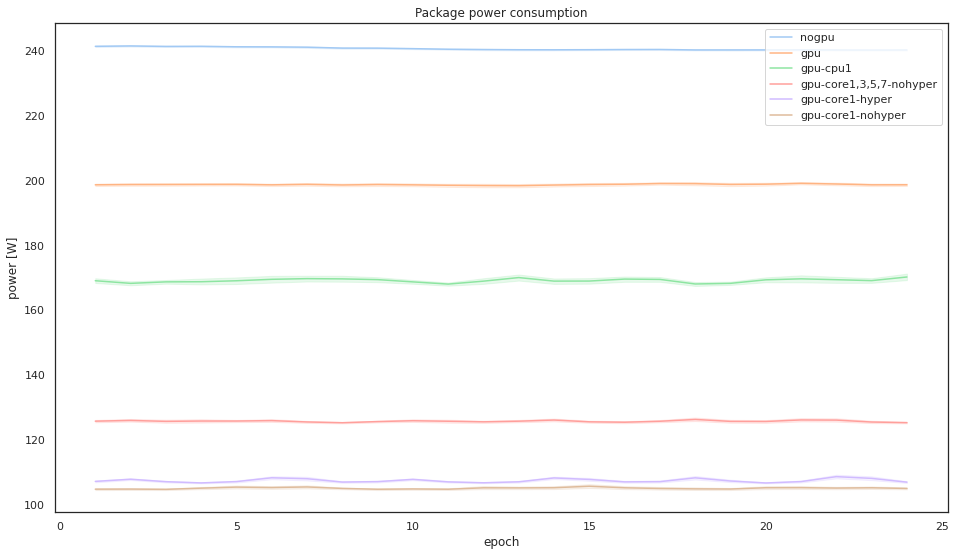

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))
df['package power'] = df['package_0 power'] + df['package_1 power']
sns.lineplot(data=df, x='epoch', y='package power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('Package power consumption')
ax.legend();

## GPU power consumption

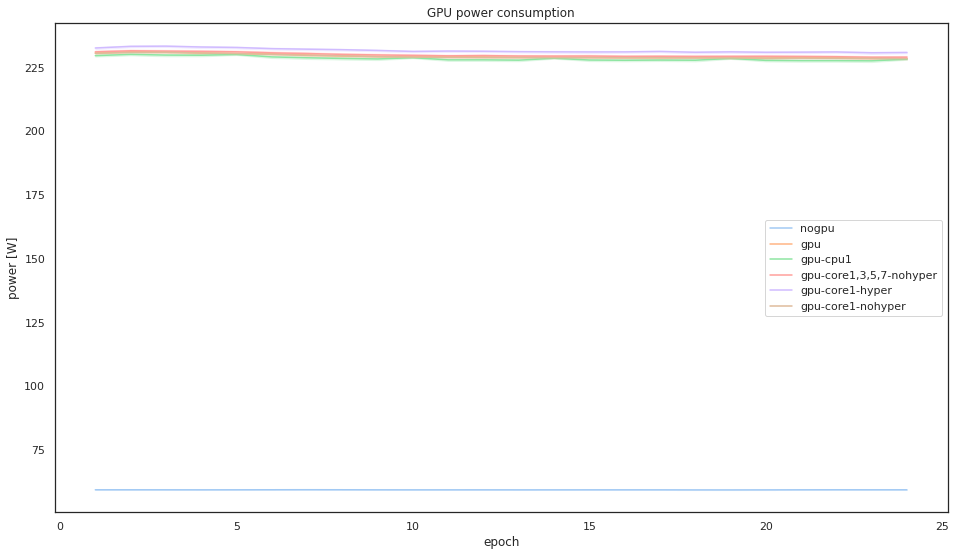

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
df['nvidia_gpu power'] = df['nvidia_gpu_0 power'] + df['nvidia_gpu_1 power']
sns.lineplot(data=df, x='epoch', y='nvidia_gpu power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();